In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Praca domowa 3 - Klasyfikacja
Zadaniem pracy domowej jest wytrenowanie 3 klasyfikatorów i porównanie ich wydajności.

## Szybki przegląd danych
Zbiór danych zawiera codzienne obserwacje pogody z wielu australijskich stacji pogodowych. Zadaniem klasyfikacji jest przewidzenie czy następnego dnia będzie padał deszcz.

Dane zostały już przygotowane do pracy, zawierają tylko wartości numeryczne. Spójrzmy jak wyglądają ich rozkłady. 

In [2]:
raw = pd.read_csv('australia.csv')

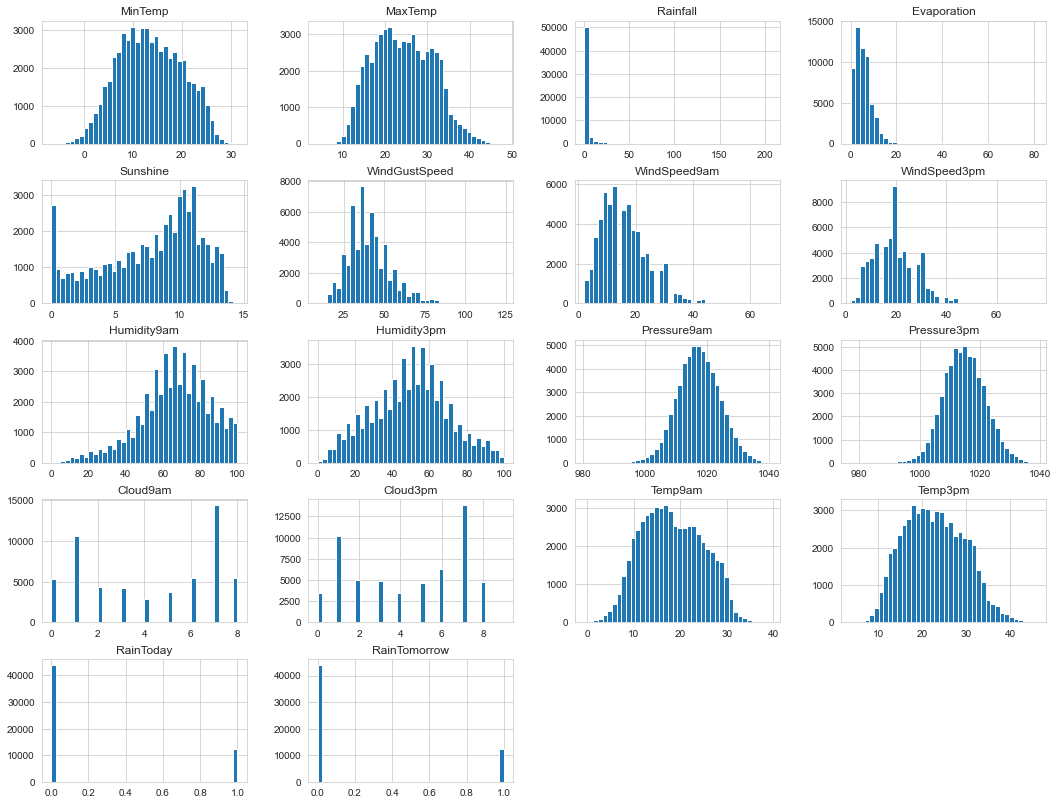

In [74]:
raw.hist(figsize=(18,14), bins=40)
plt.show()

Wiele kolumn posiada rozkład daleki od normalnego (np.`Rainfall`, `Evaporation`) oraz kolumny mają wielkości różnego rzędu (np `Evaporation` i `Pressure3pm`). Dlatego potrzebne będzie ustandaryzowanie wszystkich danych poza `RainToday`, która jest cechą kategoryczna zakodowaną zerojedynkowo.

## Podział na zbiór treningowy/testowy i preproccessing
Dzielimy zbiór na treningowy i testowy w stosunku 80:20. Proporcje udziału klas w zmiennej celu są zachowane w obu zbiorach.

In [4]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(raw.drop(columns=['RainTomorrow']), raw['RainTomorrow'], test_size=0.2, random_state=0)

In [5]:
print(y_train.value_counts()/len(y_train))
print(y_test.value_counts()/len(y_test))

0    0.778514
1    0.221486
Name: RainTomorrow, dtype: float64
0    0.784651
1    0.215349
Name: RainTomorrow, dtype: float64


In [6]:
raw.columns

Index(['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine',
       'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am',
       'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm',
       'Temp9am', 'Temp3pm', 'RainToday', 'RainTomorrow'],
      dtype='object')

In [7]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer

numeric_columns = ['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine',
       'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am',
       'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm',
       'Temp9am', 'Temp3pm']

numeric_transformer = StandardScaler()

preprocessing = ColumnTransformer([
    ('numeric', numeric_transformer, numeric_columns),
    ('passthough', FunctionTransformer(lambda x: x, lambda x: x), ['RainToday'])], remainder='drop')

x_train = preprocessing.fit_transform(x_train)
x_test = preprocessing.transform(x_test)

## Regresja logistyczna
Pierwszym modelem który wykorzystamy do klasyfikacji jest regresja logistyczna. W bibliotece scikit-learn, jednym z hiperparametrów jest `C`. Jest to parametr który jest odwrotnością siły regularyzacji modelu. Implementacja w scikit-learn pozwala wybrać jeden z kilku algorytmów do optymalizacji, można to zrobić za pomocą hiperparametru `solver`.

In [8]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

lr = LogisticRegression(C=0.1, solver='liblinear')

lr.fit(x_train, y_train)

y_pred_lr = lr.predict(x_test)
y_proba_lr = lr.predict_proba(x_test)

## SVC
Do klasyfikacji użyjemy również maszynę wektorów nośnych. Obiekt `SVC` z scikit-learn posiada również posiada parametr `C`, który pełni tę samą rolę co w przypadku `LogisticRegression`. Parametr `gamma` jest parametrem funkcji podobieństwa (funkcja wyznaczająca podobieństwo danej próbki do innej, w ten sposób 'tworzy' się na bieżąco nowe cechy próbki). Parametr `probability` nastawiony na `True` pozwala wyznaczać pewność klasyfikacji, co się przyda potem przy rysowaniu ROC.

In [57]:
from sklearn.svm import SVC
svc = SVC(C=10, gamma='auto', probability=True)
svc.fit(x_train, y_train)
y_pred_svc = svc.predict(x_test)
y_proba_svc = svc.predict_proba(x_test)

## Las Losowy
Osatnim klysyfikatorem, który będziemy rozważać jest las losowy. Polega on na stworzeniu wielu prostych drzew decyzyjnych i rozstrzygnięciu wyniku klasyfikacji za pomocą głosowania. Parametr `n_estimators` wyznacza z ilu drzew ma być zbudowany las (domyślna wartość to 100). Parametr `max_depth` określa maksymalną wysokość drzewa, jest więc jednym z parametrów do ustawiania regularyzacji modelu.

In [72]:
from sklearn.ensemble import RandomForestClassifier
random_forest = RandomForestClassifier(n_estimators=200, max_depth=30)
random_forest.fit(x_train, y_train)
y_pred_forest = random_forest.predict(x_test)
y_proba_forest = random_forest.predict_proba(x_test)

## Porównanie modeli
Porównajmy teraz działanie modeli za pomocą kilku metryk. Wszystki wyniki są na podstawie zbioru testowego.
### Precyzja/czułość/F1
Na podstawie precyzji, czułości i metryki F1 (średnia harmoniczna precyzji i czułości) można stwierdzić że modele działają bardzo podobnie. Różnice są minimalne i sięgają maksymalnie około 2% (np.różnica czułości między `LogisticRegression` i `SVC`).

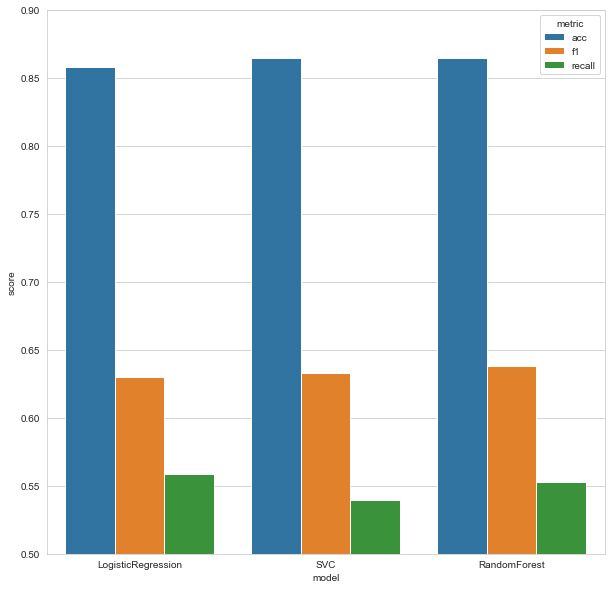

In [70]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score


results_df = pd.DataFrame([['LogisticRegression', 'acc', accuracy_score(y_test, y_pred_lr)],
              ['LogisticRegression', 'f1', f1_score(y_test, y_pred_lr)],
              ['LogisticRegression', 'recall', recall_score(y_test, y_pred_lr)],
              ['SVC', 'acc', accuracy_score(y_test, y_pred_svc)],
              ['SVC', 'f1', f1_score(y_test, y_pred_svc)],
              ['SVC', 'recall', recall_score(y_test, y_pred_svc)],
              ['RandomForest', 'acc', accuracy_score(y_test, y_pred_forest)],
              ['RandomForest', 'f1', f1_score(y_test, y_pred_forest)],
              ['RandomForest', 'recall', recall_score(y_test, y_pred_forest)]], columns=['model', 'metric', 'score'])
sns.set_style("whitegrid")

fig, ax = plt.subplots(figsize=(10,10))
g = sns.barplot(data=results_df, x='model', y='score', hue='metric')
g.set(ylim=(0.5,0.9))
plt.show()

### ROC / AUC

Więcej różnic można zaobserwować na wykresie ROC (czyli wykres odsetek prawdziwie pozytywnych vs odsetek fałszywie pozytywnych). ROC pozwala zaobserwować jak zmienia się działanie modelu gdy zmieniamy próg decyzyjny prawdobopodobieństwa klasyfkiacji (o ile większym odsetkiem błędów fałszywie pozytywnych spowoduje zwiększenie czułości). Tutaj widać że w przypadku potrzeby wysokiej czułości `>0.8` (większa pewność że nie zaskoczy nas niezapowiedziany deszcz), znacznie gorzej sobie radzi sobie `SVC` od pozostałych. gdyż będzie się to wiązało z bardzo dużą liczbą fałszywie pozytywnych predykcji. Patrząc na wartość pola pod tym wykresem (AUC) najlepszy jest model `RandomForest`.

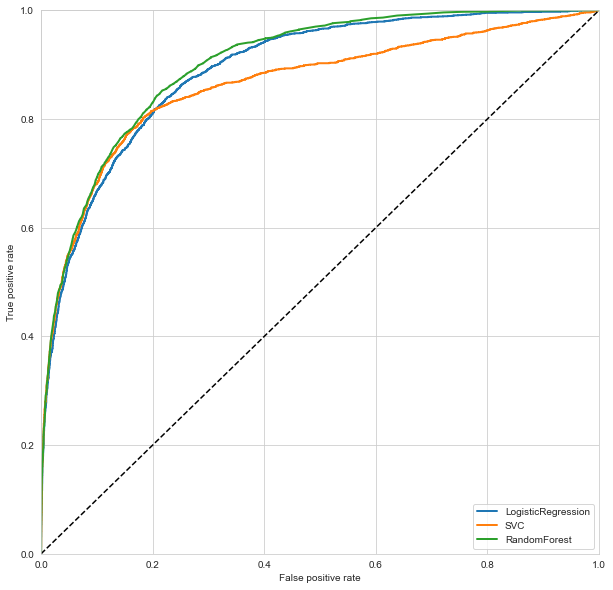

AUC LogisticRegression:  0.7498327230676702
AUC SVC:  0.7471443006392683
AUC RandomForest: 0.7516028653204568


In [71]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

fpr_lr, tpr_lr, thresholds_lr = roc_curve(y_test, y_proba_lr[:,1])
fpr_svc, tpr_svc, thresholds_svc = roc_curve(y_test, y_proba_svc[:,1])
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_test, y_proba_forest[:,1])


plt.figure(figsize=(10, 10))
plt.plot(fpr_lr, tpr_lr, linewidth=2, label='LogisticRegression')
plt.plot(fpr_svc, tpr_svc, linewidth=2, label='SVC')
plt.plot(fpr_forest, tpr_forest, linewidth=2, label='RandomForest')
plt.plot([0, 1], [0, 1], 'k--')
plt.axis([0, 1, 0, 1])
plt.legend(loc="lower right")
plt.xlabel('False positive rate')   
plt.ylabel('True positive rate') 
plt.show()
print('AUC LogisticRegression: ', roc_auc_score(y_test, y_pred_lr))
print('AUC SVC: ', roc_auc_score(y_test, y_pred_svc))
print('AUC RandomForest:', roc_auc_score(y_test,y_pred_forest))

## Wnioski
Spośród testowanych modeli najgorzej sobie wypadł `SVC`. Jego trenowanie zajęło bardzo dużo czasu i wynik był porównywalny (wynik F1) lub gorszy (czułość, ROC, AUC) od `LogisticRegression`. Wypada pomiędzy testowanymi modelami jeśli nie zależy nam na dużej czułości (krzywa ROC), jednak nie jest to warte bardzo długiego czasu treningu. Najlepszym modelem okazał się `RandomForest`, który uzyskał najlepsze wyniki w każdej z metryk.